## Preparation
First, I import the libraries and look at the data folder to see the exact names  of the files which I gonna work with.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                  # plots

from scipy.optimize import minimize  

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/mlcourse/accidental-deaths-in-usa-monthly.csv
/kaggle/input/mlcourse/hostel_factors.csv
/kaggle/input/mlcourse/flight_delays_test.csv
/kaggle/input/mlcourse/beauty.csv
/kaggle/input/mlcourse/adult_train.csv
/kaggle/input/mlcourse/currency.csv
/kaggle/input/mlcourse/samsung_test.txt
/kaggle/input/mlcourse/ads.csv
/kaggle/input/mlcourse/titanic_test.csv
/kaggle/input/mlcourse/credit_scoring_sample.csv
/kaggle/input/mlcourse/samsung_train_labels.txt
/kaggle/input/mlcourse/websites_test_sessions.csv
/kaggle/input/mlcourse/site_dic.pkl
/kaggle/input/mlcourse/titanic_train.csv
/kaggle/input/mlcourse/samsung_test_labels.txt
/kaggle/input/mlcourse/winequality-white.csv
/kaggle/input/mlcourse/video_games_sales.csv
/kaggle/input/mlcourse/flight_delays_train.csv
/kaggle/input/mlcourse/microchip_tests.txt
/kaggle/input/mlcourse/adult.data.csv
/kaggle/input/mlcourse/affairs.csv
/kaggle/input/mlcourse/weights_heights.csv
/kaggle/input/mlcourse/medium_posts.csv
/kaggle/input/mlcourse/te

## Reading the data


I will work with **ads.csv** and **currency.csv** files (ads watched per hour and in-game currency spend per day). The first column is Time for both.

In [2]:
ads = pd.read_csv('../input/mlcourse/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('../input/mlcourse/currency.csv', index_col=['Time'], parse_dates=['Time'])


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


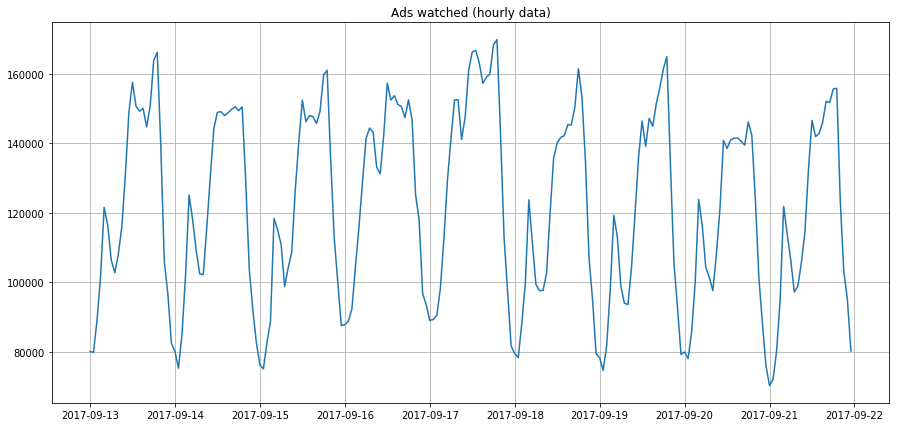

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

There is clear seasonality in ads watched.

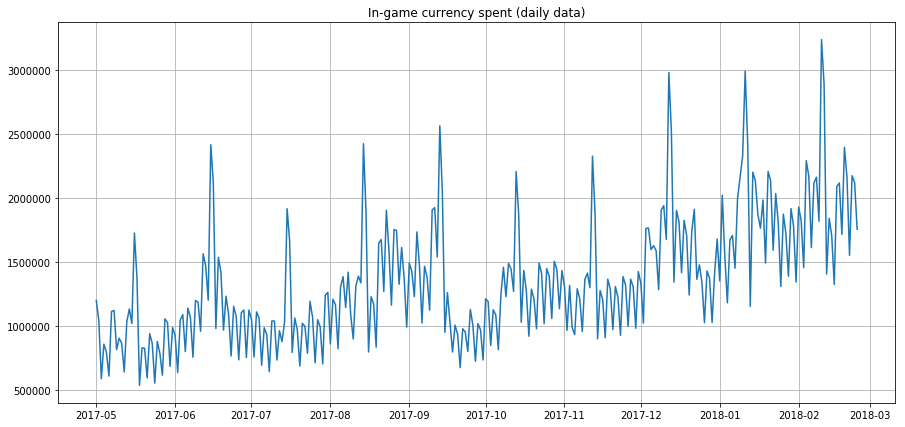

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

And in currency series as well/
## Prepare forecast quality metrics

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import  mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 1. Statistical approach
## 1-A Simple Moving Average model
(the future value of our variable depends on the average of its  k  previous values)

* Simplest moving average for 1-step ahead prediction:

In [6]:
def moving_average(series, k):
    """
        Calculate average of last n observations
    """
    return np.average(series[-k:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

* Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend (especially useful with noisy financial data)

In [7]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

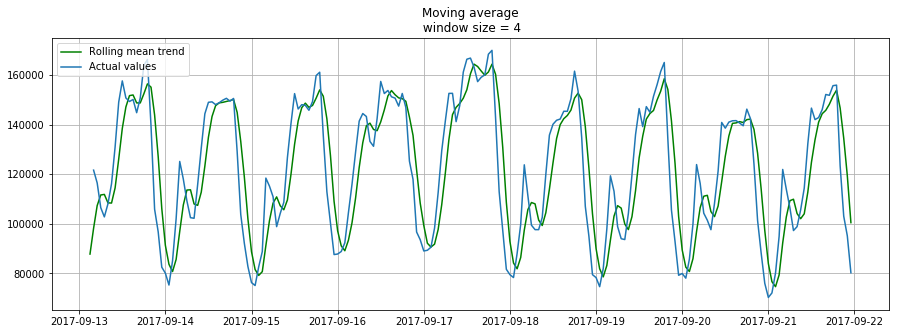

In [8]:
plotMovingAverage(ads, 4) 

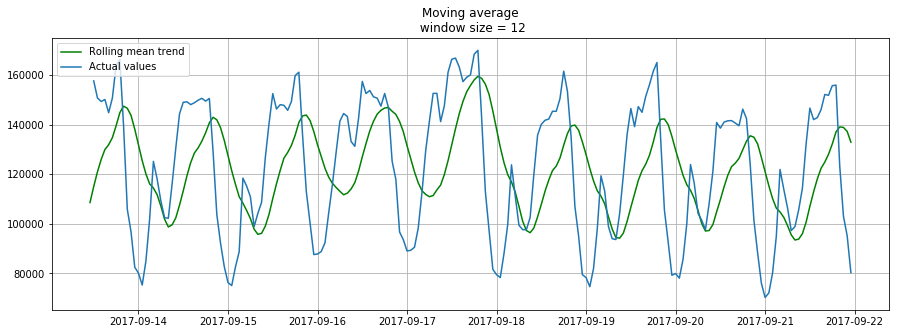

In [9]:
plotMovingAverage(ads, 12) 

Ok, here the periodic component looks more regular, but the model reflects all changes in the real data  with certain delay.

Let's plot

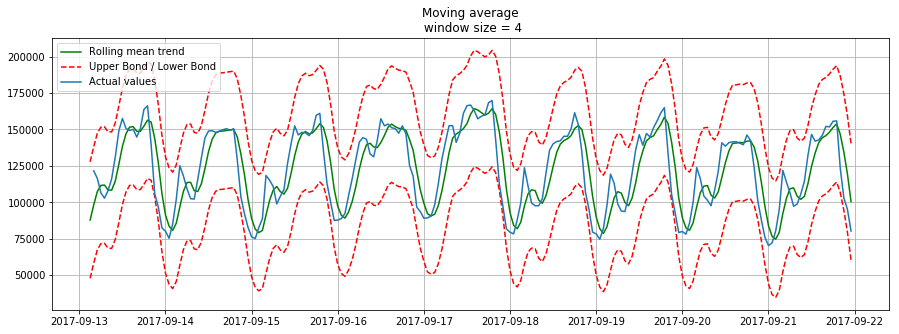

In [10]:
plotMovingAverage(ads, 4, plot_intervals=True)

And the same picture for currency.

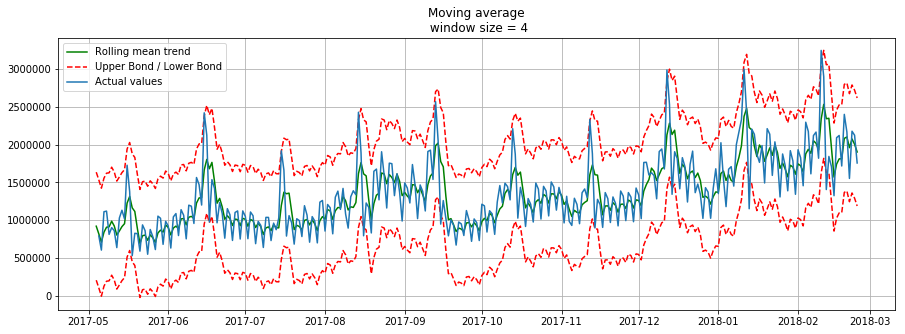

In [11]:
plotMovingAverage(currency, 4, plot_intervals=True)

Theoretically, I would like to see of there are any outliers /anomalies. "Unfortunately", there is no of the in the original **ads** series, so I will introduce them artificially to show how the procedure could work.


In [12]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

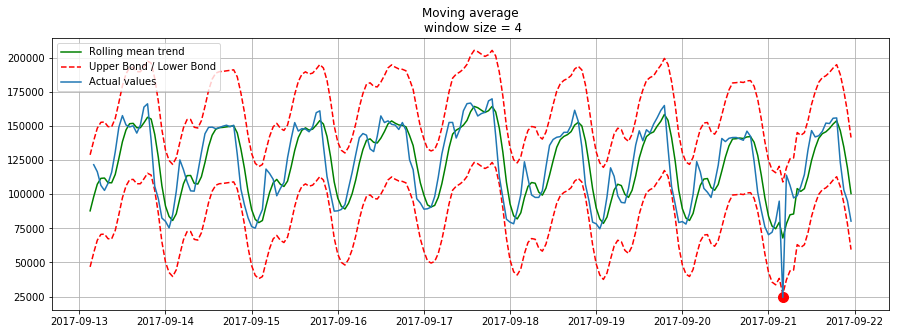

In [13]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

And the same picture for original(!) **currency** series:

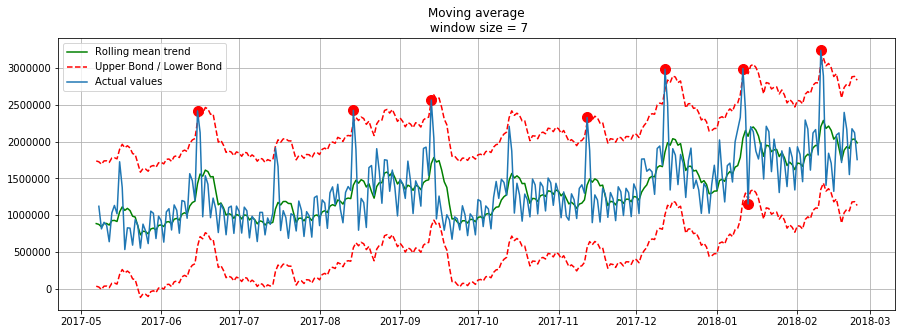

In [14]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

## 1-B Weighted Moving Average model
Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

In [15]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [16]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

Actually, here we have no idea how the weights should be constructed (apart from being non-negative and summing to 1).



## 1-C Triple exponential smoothing a.k.a. Holt-Winters

In [17]:
class HoltWinters:    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
         
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

I will estimate the parameters automatically, using CV.

In [18]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [19]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )
# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11681811415263998 0.002674202051183794 0.059665015439133884
CPU times: user 3.58 s, sys: 0 ns, total: 3.58 s
Wall time: 3.57 s


In [20]:
Add some code for plotting the results:

SyntaxError: invalid syntax (<ipython-input-20-a1f1d071b66f>, line 1)

In [21]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

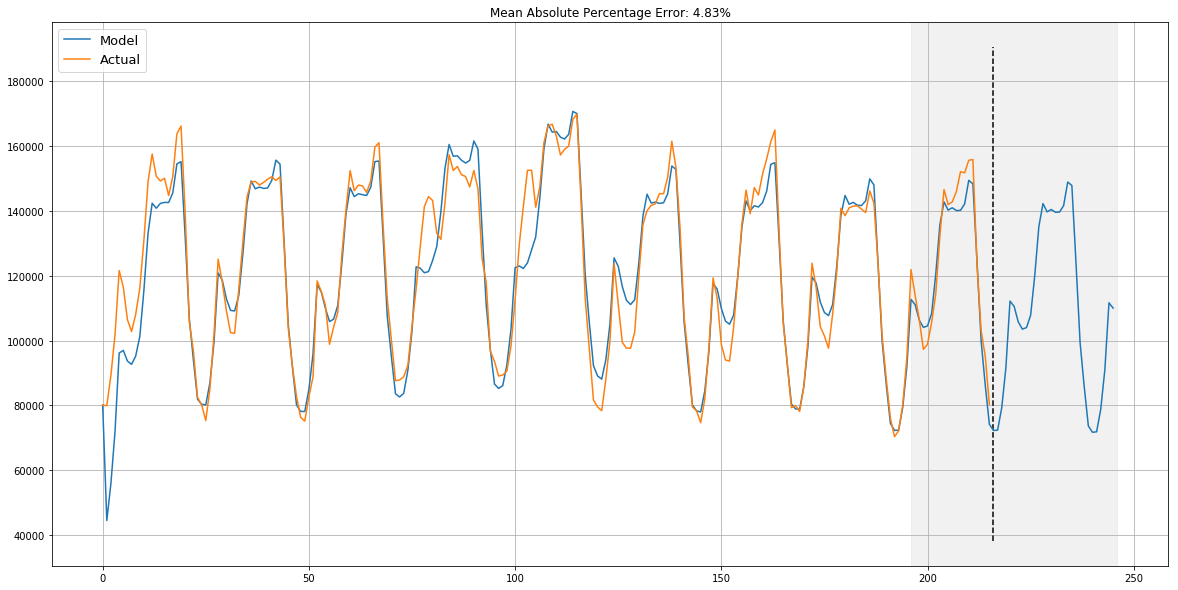

In [22]:
plotHoltWinters(ads.Ads)

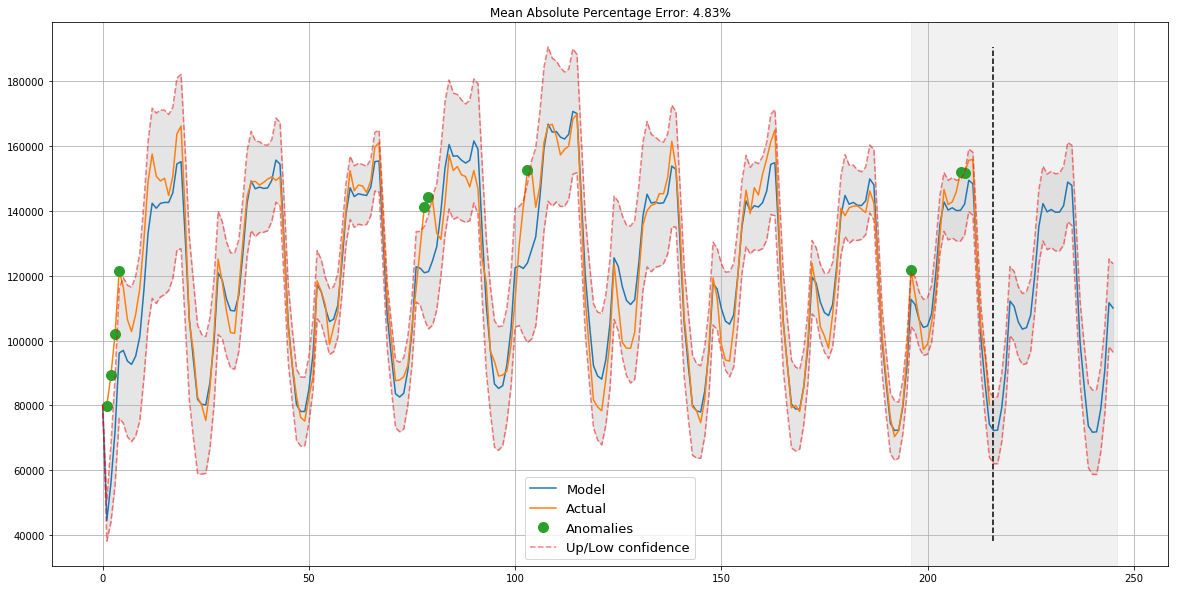

In [23]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

The model was able to successfully approximate the initial time series, capturing the daily seasonality, overall downwards trend, and even some anomalies.

The same algorithm applied to the second series:

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 6.02 s, sys: 20 ms, total: 6.04 s
Wall time: 6.01 s


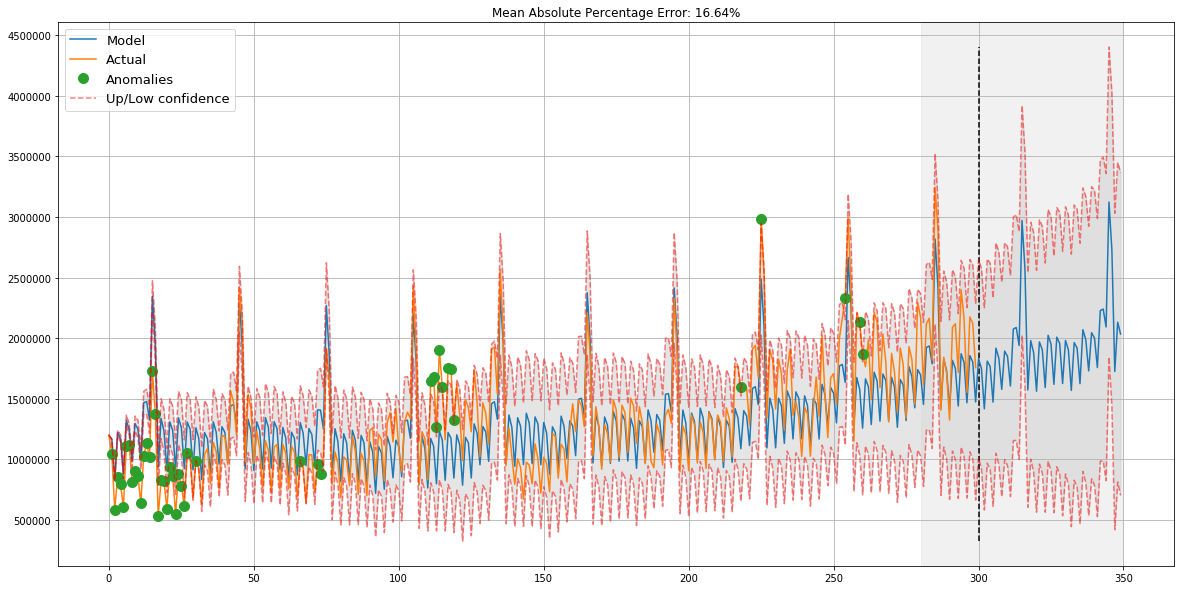

In [24]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python